<Axes: xlabel='Date_Symptoms'>

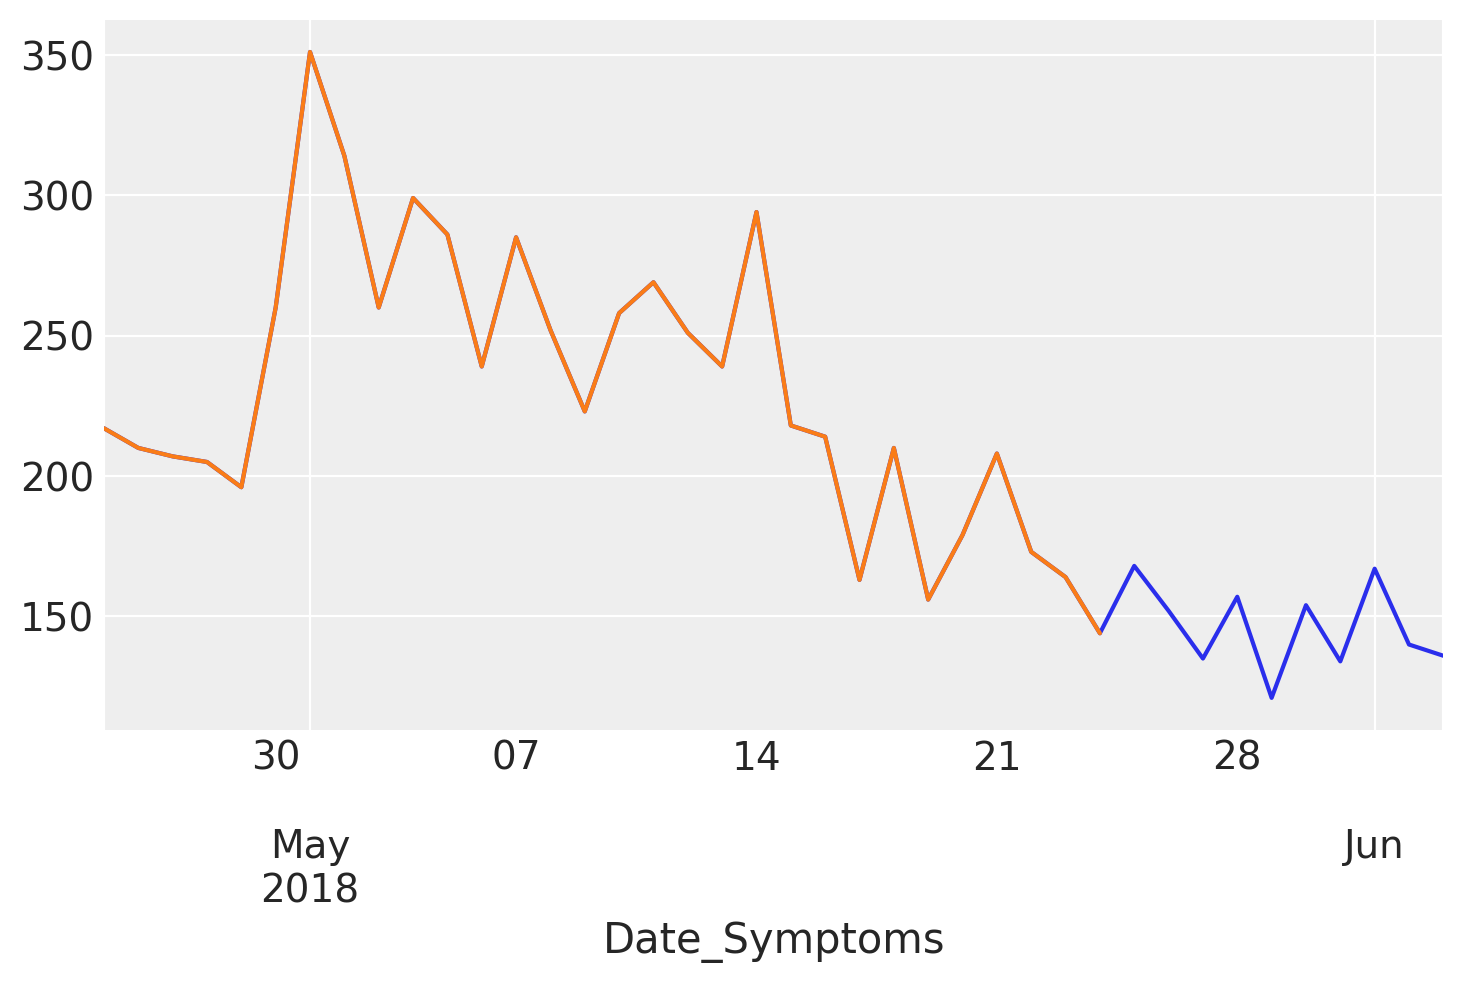

In [825]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

start_index = 1900
M = 30
D = 10

y = train_df.sum(axis=1)[start_index: start_index + M + D]
y.index = pd.to_datetime(y.index)
y.index.freq = y.index.inferred_freq

y_train = y[:-D]
y.plot()
y_train.plot()

In [826]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [827]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

In [828]:
t = np.arange(0, len(y_train))
def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)






In [829]:

with pm.Model() as model:
    t_shared = pm.Data("t", t)
    biweekly_fourier_shared = create_fourier_features(t_shared, n=20, p=14)
    weekly_fourier_shared = create_fourier_features(t_shared, n=10, p=14)


    # Trend
    b0 = pm.Normal("b0", mu=0, sigma=2)
    b1 = pm.Normal("b1", mu=0, sigma=2)
    trend = pm.Deterministic("trend", b0 + b1 * t_shared)
    
    # Fourier Seasonality
    beta_biweekly = pm.Normal("beta_biweekly", 0, 0.1, shape=biweekly_fourier_shared.shape[1])
    seasonality_biweekly = pm.Deterministic(
        "seasonality_biweekly", pm.math.dot(biweekly_fourier_shared, beta_biweekly)
    )

    beta_weekly = pm.Normal("beta_weekly", 0, 0.05, shape=weekly_fourier_shared.shape[1])
    seasonality_weekly = pm.Deterministic(
        "seasonality_weekly", pm.math.dot(weekly_fourier_shared, beta_weekly)
    )

    
    log_lam = trend + seasonality_biweekly #+ seasonality_weekly 
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))


    alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
    y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha, observed=y_train,shape=t_shared.shape)
    
    idata = pm.sample(**sampler_kwargs())

    

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.47,7
,1300,0,0.45,7


In [830]:
with model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample

    last_t = t[-1]

    
    forecast_t = np.arange(last_t, last_t + D)
    pm.set_data({'t':forecast_t})
    idata = pm.sample_posterior_predictive(idata, var_names=['y_hat', 'lam'], extend_inferencedata=True, predictions=True)



Sampling: [y_hat]


Output()

Sampling: [beta_biweekly, y_hat]


Output()

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_37508/3691263528.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  y_post_samples = az.extract_dataset(idata, group="posterior_predictive", num_samples=100)["y_hat"]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_37508/3691263528.py:10: FutureWarning: extract_dataset has been deprecated, please use extract
  y_pred_samples = az.extract_dataset(idata, group="predictions", num_samples=100)["lam"]


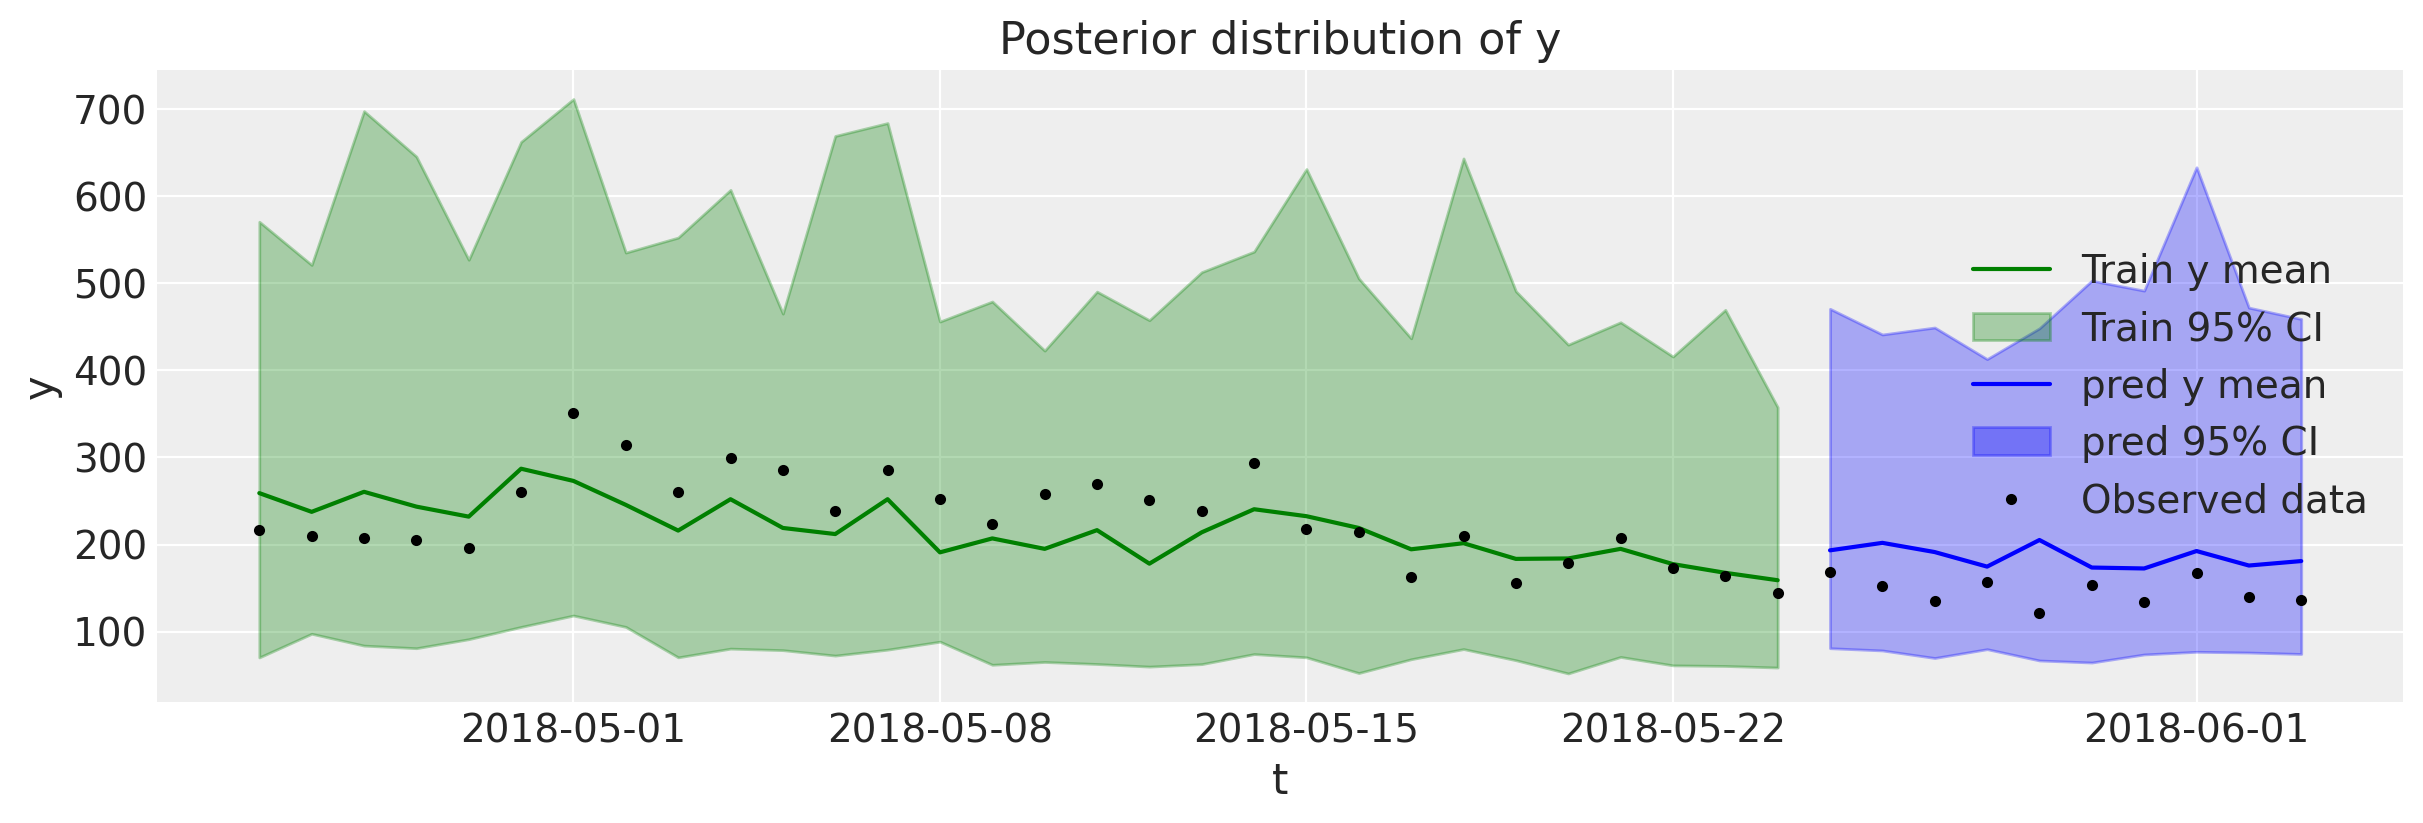

In [831]:


# in sample
y_post_samples = az.extract_dataset(idata, group="posterior_predictive", num_samples=100)["y_hat"]
mean_train = np.percentile(y_post_samples, 50, axis=1)
lower_train = np.percentile(y_post_samples, 2.5, axis=1)
upper_train = np.percentile(y_post_samples, 97.5, axis=1)



# pred
y_pred_samples = az.extract_dataset(idata, group="predictions", num_samples=100)["lam"]

mean_pred = np.percentile(y_pred_samples, 50, axis=1)
lower_pred = np.percentile(y_pred_samples, 2.5, axis=1)
upper_pred = np.percentile(y_pred_samples, 97.5, axis=1)



# plot the results
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()

# Plot CI for training data
ax.plot(y_train.index, mean_train, color='green', label="Train y mean")
ax.fill_between(y_train.index, lower_train, upper_train, color='green', alpha=0.3, label='Train 95% CI')

# # Plot CI for predictions
ax.plot(y[-D:].index, mean_pred, color='blue', label="pred y mean")
ax.fill_between(y[-D:].index, lower_pred, upper_pred, color='blue', alpha=0.3, label='pred 95% CI')


ax.plot(y.index, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("t")
plt.ylabel("y")
plt.title("Posterior distribution of y")
plt.legend()

Proportion